In [147]:
import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor


import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error



### 데이터 전처리

In [148]:
train_data = pd.read_csv("data/train.csv", index_col=False)
test_data = pd.read_csv("data/test.csv", index_col=False)

In [149]:
'''
1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 타겟 변수인 집의 가격
4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수
6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 근처 15 가구의 주거 공간, 평방 피트
21. sqft_lot15 : 근처 15가구의 부지, 평방 피트
'''

'\n1. ID : 집을 구분하는 번호\n2. date : 집을 구매한 날짜\n3. price : 타겟 변수인 집의 가격\n4. bedrooms : 침실의 수\n5. bathrooms : 침실당 화장실 개수\n6. sqft_living : 주거 공간의 평방 피트\n7. sqft_lot : 부지의 평방 피트\n8. floors : 집의 층수\n9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)\n10. view : 집이 얼마나 좋아 보이는지의 정도\n11. condition : 집의 전반적인 상태\n12. grade : King County grading 시스템 기준으로 매긴 집의 등급\n13. sqft_above : 지하실을 제외한 평방 피트\n14. sqft_basement : 지하실의 평방 피트\n15. yr_built : 집을 지은 년도\n16. yr_renovated : 집을 재건축한 년도\n17. zipcode : 우편번호\n18. lat : 위도\n19. long : 경도\n20. sqft_living15 : 근처 15 가구의 주거 공간, 평방 피트\n21. sqft_lot15 : 근처 15가구의 부지, 평방 피트\n'

In [150]:
train_data.shape, test_data.shape

((15035, 21), (6468, 20))

In [151]:
# train 데이터와 test 데이터 분포를 확인하기 위해서 두 데이터 병합

## train_data의 타겟변수를 y에 저장 후 삭제
y = train_data['price']
del train_data['price']
# train_data.drop(columns=['price'], inplace=True) 이걸 주로 사용하긴함.

## train_data와 test_data 병합
data = pd.concat((train_data, test_data), axis=0)

len(data)


21503

In [152]:
data.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [153]:
# 결측치 확인
data.isnull().sum()

id               0
date             0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

In [154]:
data.describe()

,id,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,21503.000000,21503.000000,21503.000000,21503.000000,2.150300e+04,21503.000000,21503.000000,21503.000000,21503.000000,21503.000000,21503.000000,21503.000000,21503.000000,21503.000000,21503.000000,21503.000000,21503.000000,21503.000000,21503.000000
mean,10751.000000,3.371762,2.116042,2081.441334,1.511715e+04,1.495140,0.007580,0.234618,3.409710,7.659164,1789.765986,291.675348,1971.055016,84.741943,98077.897968,47.560121,-122.213786,1987.242664,12774.529089
std,6207.525755,0.930026,0.770018,918.669624,4.147591e+04,0.540183,0.086737,0.766453,0.650066,1.174422,828.481664,442.645882,29.372398,402.452836,53.489890,0.138615,0.140833,685.579479,27334.995914
min,0.000000,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,5375.500000,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1200.000000,0.000000,1951.000000,0.000000,98033.000000,47.471100,-122.328000,1490.000000,5100.000000
50%,10751.000000,3.000000,2.250000,1914.000000,7.616000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,98065.000000,47.571900,-122.230000,1840.000000,7620.000000
75%,16126.500000,4.000000,2.500000,2550.000000,1.068600e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,560.000000,1997.000000,0.000000,98117.000000,47.678100,-122.125000,2370.000000,10085.000000
max,21502.000000,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


In [155]:
del data['id']

In [156]:
# date를 년, 월, 일로 분리하여 파생변수 생성 후 삭제
data['year'] = data['date'].str[:4].astype(int)
data['month'] = data['date'].str[4:6].astype(int)
data['day'] = data['date'].str[6:8].astype(int)

del data['date']
data.head(3)

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,...,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year,month,day
0,3,1.0,1180,5650,1.0,0,0,3,7,1180,...,1955,0,98178,47.5112,-122.257,1340,5650,2014,10,13
1,2,1.0,770,10000,1.0,0,0,3,6,770,...,1933,0,98028,47.7379,-122.233,2720,8062,2015,2,25
2,3,2.0,1680,8080,1.0,0,0,3,8,1680,...,1987,0,98074,47.6168,-122.045,1800,7503,2015,2,18


In [157]:
# yr_built(지어진 년도)는 year(거래된날짜)와의 차를 구해 age(연식) 파생변수 생성 
# yr_renovated(리모델링 연도)를 확인 후 renovated(리모델링 여부)
# yr_renovated와 year의 차를 구해 리모델링된지 몇년된지 파생변수(renovated_age)로 생성

data['age'] = data['year'] - data['yr_built']


data['renovated'] = (data['yr_renovated'] > 0).astype(int)

# 리모델링된지 몇 년 됐는지 계산 (renovated_age)
data['renovated_age'] = data.apply(
    lambda row: row['year'] - row['yr_renovated'] if row['renovated'] == 1 else 0,
    axis=1
)


In [158]:
data[['yr_built', 'yr_renovated', 'year', 'renovated', 'age', 'renovated_age']][data['renovated']==1].head(3)

,yr_built,yr_renovated,year,renovated,age,renovated_age
26,1930,2002,2014,1,84,12.0
78,1900,1999,2014,1,114,15.0
149,1957,1991,2015,1,58,24.0


In [159]:
data.describe()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,...,lat,long,sqft_living15,sqft_lot15,year,month,day,age,renovated,renovated_age
count,21503.000000,21503.000000,21503.000000,2.150300e+04,21503.000000,21503.000000,21503.000000,21503.000000,21503.000000,21503.000000,...,21503.000000,21503.000000,21503.000000,21503.000000,21503.000000,21503.000000,21503.000000,21503.000000,21503.000000,21503.000000
mean,3.371762,2.116042,2081.441334,1.511715e+04,1.495140,0.007580,0.234618,3.409710,7.659164,1789.765986,...,47.560121,-122.213786,1987.242664,12774.529089,2014.320560,6.583546,15.684416,43.265544,0.042459,0.782356
std,0.930026,0.770018,918.669624,4.147591e+04,0.540183,0.086737,0.766453,0.650066,1.174422,828.481664,...,0.138615,0.140833,685.579479,27334.995914,0.466703,3.111287,8.634354,29.373312,0.201639,4.902289
min,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,...,47.155900,-122.519000,399.000000,651.000000,2014.000000,1.000000,1.000000,-1.000000,0.000000,-1.000000
25%,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1200.000000,...,47.471100,-122.328000,1490.000000,5100.000000,2014.000000,4.000000,8.000000,18.000000,0.000000,0.000000
50%,3.000000,2.250000,1914.000000,7.616000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,...,47.571900,-122.230000,1840.000000,7620.000000,2014.000000,6.000000,16.000000,39.000000,0.000000,0.000000
75%,4.000000,2.500000,2550.000000,1.068600e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,...,47.678100,-122.125000,2370.000000,10085.000000,2015.000000,9.000000,23.000000,63.000000,0.000000,0.000000
max,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,...,47.777600,-121.315000,6210.000000,871200.000000,2015.000000,12.000000,31.000000,115.000000,1.000000,80.000000


In [160]:
data[['yr_built', 'yr_renovated', 'year', 'renovated', 'age', 'renovated_age']][data['age']==-1]

,yr_built,yr_renovated,year,renovated,age,renovated_age
1264,2015,0,2014,0,-1,0.0
1920,2015,0,2014,0,-1,0.0
5303,2015,0,2014,0,-1,0.0
5654,2015,0,2014,0,-1,0.0
10110,2015,0,2014,0,-1,0.0
11890,2015,0,2014,0,-1,0.0
14428,2015,0,2014,0,-1,0.0
14484,2015,0,2014,0,-1,0.0
14563,2015,0,2014,0,-1,0.0
14776,2015,0,2014,0,-1,0.0


In [161]:
# 중복 데이터 삭제
del data['yr_built']
del data['yr_renovated']

In [162]:
len(data.columns)

22

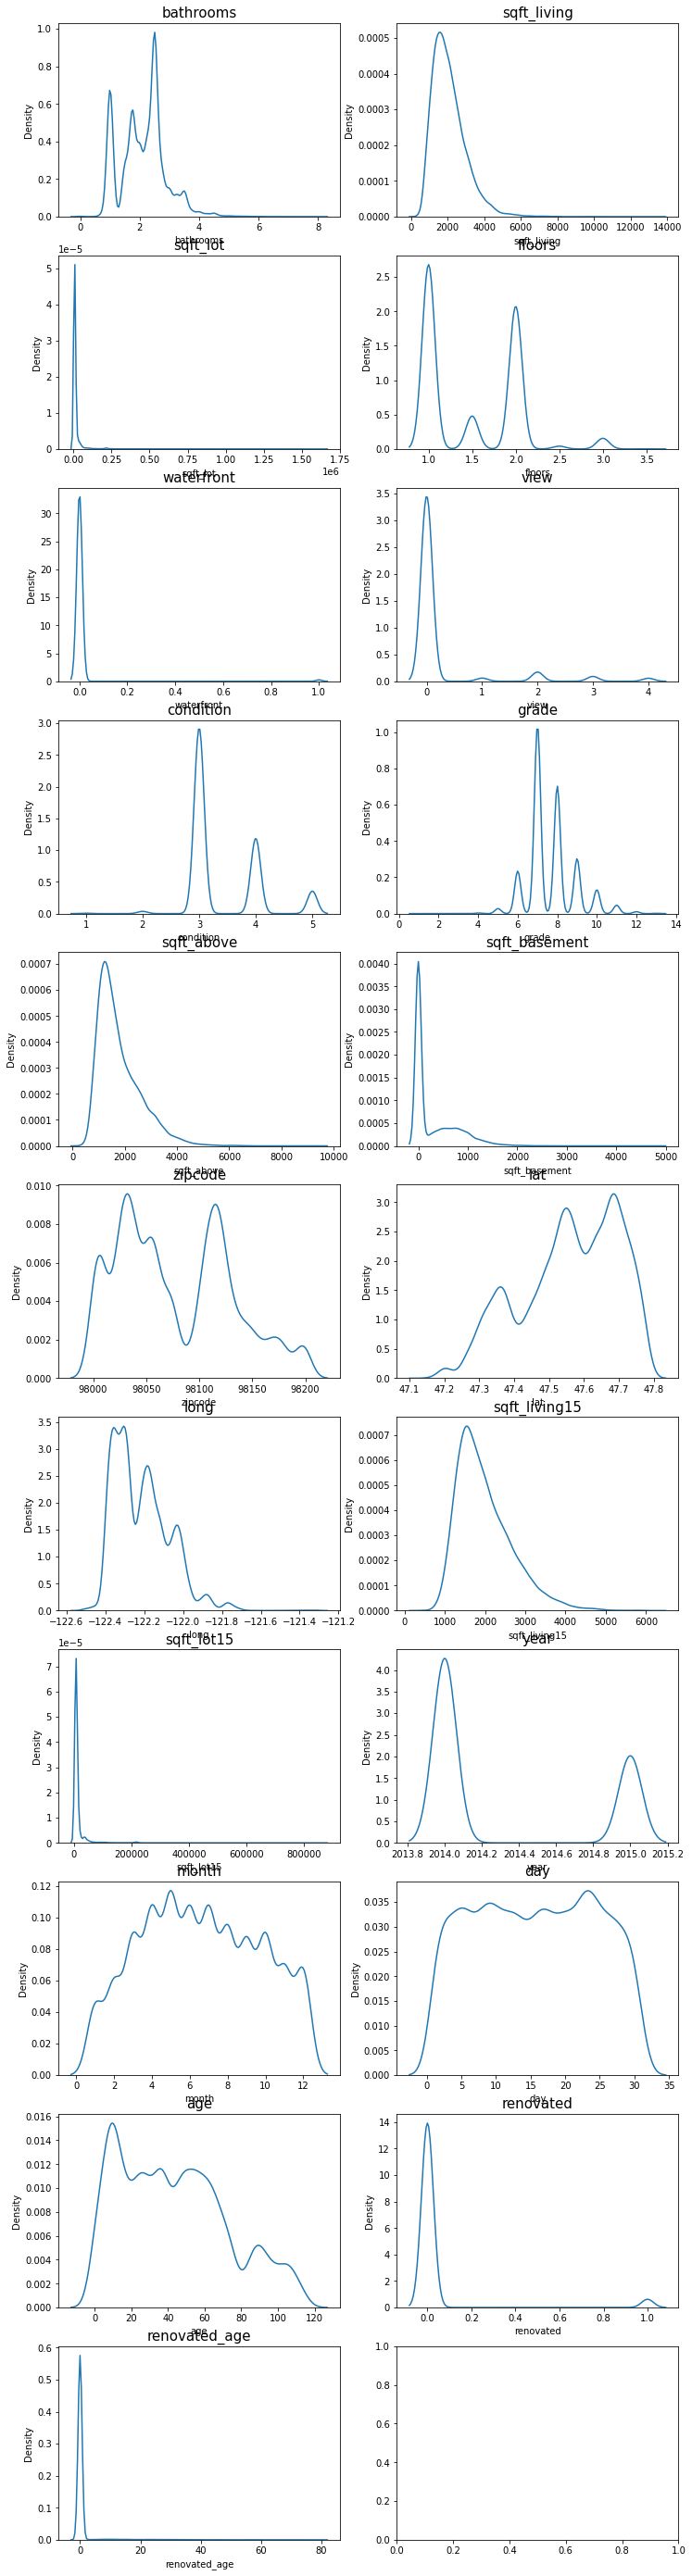

In [163]:
# 데이터 분포 알아보기(kdeplot)
fig, ax = plt.subplots(11, 2, figsize=(12, 50))   # 가로스크롤 때문에 그래프 확인이 불편하다면 figsize의 x값을 조절해 보세요. 

# id 변수(count==0인 경우)는 제외하고 분포를 확인합니다.
count = 1
columns = data.columns
for row in range(11):
    for col in range(2):
        sns.kdeplot(data=data[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 22 :
            break

In [164]:
data.describe()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,...,lat,long,sqft_living15,sqft_lot15,year,month,day,age,renovated,renovated_age
count,21503.000000,21503.000000,21503.000000,2.150300e+04,21503.000000,21503.000000,21503.000000,21503.000000,21503.000000,21503.000000,...,21503.000000,21503.000000,21503.000000,21503.000000,21503.000000,21503.000000,21503.000000,21503.000000,21503.000000,21503.000000
mean,3.371762,2.116042,2081.441334,1.511715e+04,1.495140,0.007580,0.234618,3.409710,7.659164,1789.765986,...,47.560121,-122.213786,1987.242664,12774.529089,2014.320560,6.583546,15.684416,43.265544,0.042459,0.782356
std,0.930026,0.770018,918.669624,4.147591e+04,0.540183,0.086737,0.766453,0.650066,1.174422,828.481664,...,0.138615,0.140833,685.579479,27334.995914,0.466703,3.111287,8.634354,29.373312,0.201639,4.902289
min,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,...,47.155900,-122.519000,399.000000,651.000000,2014.000000,1.000000,1.000000,-1.000000,0.000000,-1.000000
25%,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1200.000000,...,47.471100,-122.328000,1490.000000,5100.000000,2014.000000,4.000000,8.000000,18.000000,0.000000,0.000000
50%,3.000000,2.250000,1914.000000,7.616000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,...,47.571900,-122.230000,1840.000000,7620.000000,2014.000000,6.000000,16.000000,39.000000,0.000000,0.000000
75%,4.000000,2.500000,2550.000000,1.068600e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,...,47.678100,-122.125000,2370.000000,10085.000000,2015.000000,9.000000,23.000000,63.000000,0.000000,0.000000
max,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,...,47.777600,-121.315000,6210.000000,871200.000000,2015.000000,12.000000,31.000000,115.000000,1.000000,80.000000


In [165]:
# 치우친 칼럼들 log 변환
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15', 'sqft_living15']

for c in skew_columns:
    data[c] = np.log1p(data[c].values)

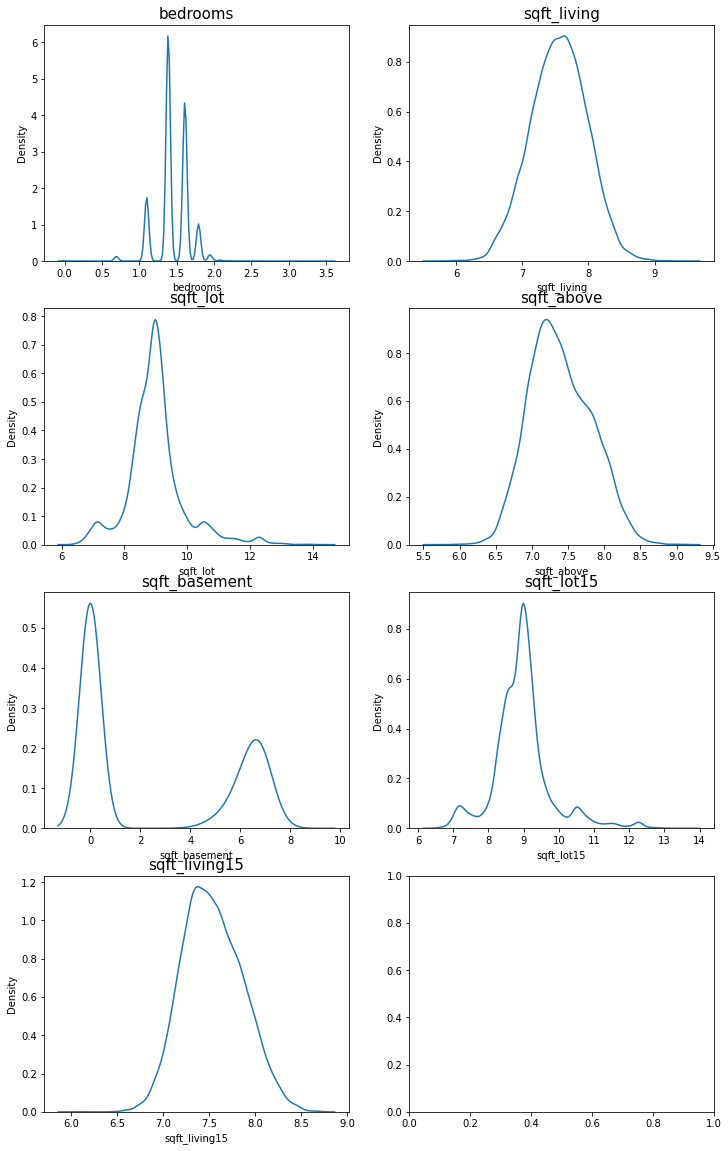

In [166]:
fig, ax = plt.subplots(4, 2, figsize=(12, 20))   # 가로스크롤 때문에 그래프 확인이 불편하다면 figsize의 x값을 조절해 보세요. 

# id 변수(count==0인 경우)는 제외하고 분포를 확인합니다.
count = 0
columns = skew_columns
for row in range(4):
    for col in range(2):
        sns.kdeplot(data=data[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 7 :
            break

### 모델학습

In [167]:
# random_stae와 모델 설정
random_state=777        # 하지만 우리는 이렇게 고정값을 세팅해 두겠습니다. 

# 모델 초기화
gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)  # XGBRegressor 호출
lightgbm = LGBMRegressor(random_state=random_state)  # LGBMRegressor 호출
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

In [168]:
#RMSE 계산함수
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))


In [169]:
# 모델 학습 및 예측 후 스코어 계산
def get_scores(models, train, y):
    df = {}
    for model in models:
        # 모델 이름 획득
        model_name = model.__class__.__name__

        # train, test 데이터셋 분리
        # random_state를 사용하여 고정하고 train과 test 셋의 비율은 8:2로 합니다.
        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)

        # 모델 학습
        model.fit(X_train, y_train)
        
        # 예측
        y_pred = model.predict(X_test)

        # 예측 결과의 rmse값 저장
        df[model_name] = rmse(y_test, y_pred)
        
        # data frame에 저장
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)

    return score_df


In [176]:
# 학습을 위한 데이터 초기화
train_data = pd.read_csv("data/train.csv", index_col=False)
test_data = pd.read_csv("data/test.csv", index_col=False)

In [177]:
# 전처리 수행하는 함수만들기
def data_preprocessing(data):
    # id 칼럼 삭제
    del data['id']

    # date를 년, 월, 일로 분리하여 파생변수 생성 후 삭제
    data['year'] = data['date'].str[:4].astype(int)
    data['month'] = data['date'].str[4:6].astype(int)
    data['day'] = data['date'].str[6:8].astype(int)

    del data['date']

    
    data['age'] = data['year'] - data['yr_built']


    data['renovated'] = (data['yr_renovated'] > 0).astype(int)

    # 리모델링된지 몇 년 됐는지 계산 (renovated_age)
    data['renovated_age'] = data.apply(
        lambda row: row['year'] - row['yr_renovated'] if row['renovated'] == 1 else 0,
        axis=1
    )
    # 중복 데이터 삭제
    del data['yr_built']
    del data['yr_renovated']
    
    # 치우친 칼럼들 log변환
    skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15', 'sqft_living15']

    for c in skew_columns:
        data[c] = np.log1p(data[c].values)

    return data

In [178]:
# 전처리 수행하는 함수만들기
# ver2
def data_preprocessing_ver2(data):
    # id 칼럼 삭제
    del data['id']
    
    data['date'] = data['date'].apply(lambda i: i[:6]).astype(int)
    
    # 치우친 칼럼들 log변환
    skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15', 'sqft_living15']

    for c in skew_columns:
        data[c] = np.log1p(data[c].values)

    return data

In [179]:
# 타겟변수 저장
y = train_data['price']
del train_data['price']

In [174]:
# train, test 전처리
X = data_preprocessing(train_data)
test_X = data_preprocessing(test_data)

In [180]:
# ver2
X = data_preprocessing_ver2(train_data)
test_X = data_preprocessing_ver2(test_data)

In [181]:
X.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,1.386294,1.00,7.074117,8.639588,1.0,0,0,3,7,7.074117,0.0,1955,0,98178,47.5112,-122.257,7.201171,8.639588
1,201502,1.098612,1.00,6.647688,9.210440,1.0,0,0,3,6,6.647688,0.0,1933,0,98028,47.7379,-122.233,7.908755,8.995041
2,201502,1.386294,2.00,7.427144,8.997271,1.0,0,0,3,8,7.427144,0.0,1987,0,98074,47.6168,-122.045,7.496097,8.923191
3,201406,1.386294,2.25,7.447751,8.827615,2.0,0,0,3,7,7.447751,0.0,1995,0,98003,47.3097,-122.327,7.713785,8.827615
4,201501,1.386294,1.50,6.966967,9.181118,1.0,0,0,3,7,6.966967,0.0,1963,0,98198,47.4095,-122.315,7.409136,9.181118


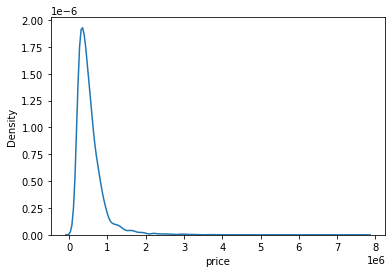

In [182]:
# y값 분포 확인
sns.kdeplot(y)
plt.show()

In [183]:
# y값도 log변환
y = np.log1p(y)
y

0        12.309987
1        12.100718
2        13.142168
3        12.458779
4        12.583999
           ...    
15030    13.322338
15031    13.822984
15032    12.793862
15033    12.899222
15034    12.691584
Name: price, Length: 15035, dtype: float64

In [184]:
result_df = get_scores(models, X, y)

In [185]:
result_df

,RMSE
GradientBoostingRegressor,175490.968996
RandomForestRegressor,171736.999102
LGBMRegressor,166657.881615
XGBRegressor,165190.445239


### 그리드 탐색

In [186]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

# 모델 생성
model = XGBRegressor(random_state=777)

# 파라미터 그리드
param_grid = {
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [50, 100, 150]
}

# GridSearchCV 설정
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',  # 평가 기준
    cv=3,  # 3-Fold Cross Validation
    verbose=2,  # 진행 상황 출력
    n_jobs=5    # 병렬 처리
)

# 학습 데이터
grid_search.fit(X, y)

# 최적의 파라미터와 점수 출력
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", -grid_search.best_score_)


Fitting 3 folds for each of 36 candidates, totalling 108 fits


/opt/conda/lib/python3.9/site-packages/pkg_resources/__init__.py:122: PkgResourcesDeprecationWarning: 0.996-ko-0.9.2 is an invalid version and will not be supported in a future release
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/pkg_resources/__init__.py:122: PkgResourcesDeprecationWarning: 0.996-ko-0.9.2 is an invalid version and will not be supported in a future release
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/pkg_resources/__init__.py:122: PkgResourcesDeprecationWarning: 0.996-ko-0.9.2 is an invalid version and will not be supported in a future release
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/pkg_resources/__init__.py:122: PkgResourcesDeprecationWarning: 0.996-ko-0.9.2 is an invalid version and will not be supported in a future release
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/pkg_resources/__init__.py:122: PkgResourcesDeprecationWarning: 0.996-ko-0.9.2 is an invalid version and will not be supported in a future release
  warni

KeyboardInterrupt: 

### 결과 뽑아내기

In [111]:
model = XGBRegressor(max_depth=5, n_estimators=100, learning_rate=0.1 ,random_state=random_state)
model.fit(X, y)
prediction = model.predict(test_X)
prediction = np.expm1(prediction)

data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission['price'] = prediction

submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, 'XGBRegressor', '005')
submission.to_csv(submission_csv_path, index=False)

print(submission_csv_path, " save success")


/aiffel/aiffel/kaggle_kakr_housing/data/submission_XGBRegressor_RMSLE_003.csv  save success


In [ ]:
#/submission_XGBRegressor_RMSLE_002.csv
#Private Score 121027.47978

#/submission_XGBRegressor_RMSLE_003.csv
#Private Score 118270.31881


### 학습 테스트용

In [136]:
# random_stae와 모델 설정
random_state=777        # 하지만 우리는 이렇게 고정값을 세팅해 두겠습니다. 

# 모델 초기화
gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)  # XGBRegressor 호출
lightgbm = LGBMRegressor(random_state=random_state)  # LGBMRegressor 호출
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

In [137]:
#RMSE 계산함수
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))


In [138]:
from sklearn.preprocessing import MinMaxScaler

# 모델 학습 및 예측 후 스코어 계산
def get_scores(models, train, y, random_state=777):
    df = {}
    for model in models:
        # 모델 이름 획득
        model_name = model.__class__.__name__

        # train, test 데이터셋 분리
        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)

        # 정규화 수행
        scaler = MinMaxScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # 모델 학습
        model.fit(X_train_scaled, y_train)
        
        # 예측
        y_pred = model.predict(X_test_scaled)

        # 예측 결과의 RMSE 값 저장
        df[model_name] = rmse(y_test, y_pred)
    
    # 결과 DataFrame 생성
    score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)

    return score_df

In [139]:
# 학습을 위한 데이터 초기화
train_data = pd.read_csv("data/train.csv", index_col=False)
test_data = pd.read_csv("data/test.csv", index_col=False)

In [140]:
# 전처리 수행하는 함수만들기
# ver2
def data_preprocessing_ver2(data):
    # id 칼럼 삭제
    del data['id']
    
    data['date'] = data['date'].apply(lambda i: i[:6]).astype(int)
    
    # 치우친 칼럼들 log변환
    skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15', 'sqft_living15']

    for c in skew_columns:
        data[c] = np.log1p(data[c].values)

    return data

In [141]:
# 타겟변수 저장
y = train_data['price']
del train_data['price']

In [142]:
# train, test 전처리
X = data_preprocessing(train_data)
test_X = data_preprocessing(test_data)

In [143]:
# y값도 log변환
y = np.log1p(y)
y

0        12.309987
1        12.100718
2        13.142168
3        12.458779
4        12.583999
           ...    
15030    13.322338
15031    13.822984
15032    12.793862
15033    12.899222
15034    12.691584
Name: price, Length: 15035, dtype: float64

In [144]:
result_df = get_scores(models, X, y)

In [145]:
result_df

,RMSE
GradientBoostingRegressor,177146.451692
RandomForestRegressor,171043.967409
LGBMRegressor,164685.584705
XGBRegressor,163099.441749


In [146]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
test_X_scaled = scaler.transform(test_X)
        
model = XGBRegressor(max_depth=5, n_estimators=100, learning_rate=0.1 ,random_state=random_state)
model.fit(X_scaled, y)
prediction = model.predict(test_X_scaled)
prediction = np.expm1(prediction)

data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission['price'] = prediction

submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, 'XGBRegressor', '005')
submission.to_csv(submission_csv_path, index=False)

print(submission_csv_path, " save success")


/aiffel/aiffel/kaggle_kakr_housing/data/submission_XGBRegressor_RMSLE_004.csv  save success
